### Modelagem Preditiva

Este notebook tem como objetivo realizar uma modelagem preditiva sobre o conjunto de dados que realizei a EDA. O foco é aplicar técnicas de ciência de dados para:

- Realizar o pré-processamento adequado;
- Construir e avaliar modelos preditivos;
- Identificar as variáveis mais importantes para a previsão;
- Reduzir dimensionalidade e refinar o modelo final.

Todo o fluxo é pensado para seguir as boas práticas de análise de dados e machine learning, com foco na interpretabilidade e desempenho.


#### Importação das bibliotecas

In [1]:
# Manipulação e Análise de Dados
import pandas as pd              
import numpy as np  

# Análises gráficas
import seaborn as sns
import matplotlib.pyplot as plt

# Utilitários personalizados
import importlib 
import sys                      

if '.' not in sys.path:
    sys.path.append('.')

import src.eda_utils as eda_utils

importlib.reload(eda_utils)

importlib.reload(eda_utils)

# Pré-processamento de dados e utilitários
from sklearn.model_selection import train_test_split 
from imblearn.pipeline import Pipeline as ImbPipeline    
from sklearn.compose import ColumnTransformer             
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.decomposition import PCA                    
from sklearn.impute import SimpleImputer     
from sklearn.model_selection import GridSearchCV      
from category_encoders import TargetEncoder, OrdinalEncoder, OneHotEncoder 

# Modelos de machine learning
from sklearn.tree import DecisionTreeClassifier         
from sklearn.ensemble import RandomForestClassifier    
from sklearn.linear_model import LogisticRegression   
from sklearn.neighbors import KNeighborsClassifier   
from sklearn.neural_network import MLPClassifier    
from xgboost import XGBClassifier            
from lightgbm import LGBMClassifier        

# Avaliação de modelos
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict 
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score 
from imblearn.over_sampling import SMOTE                 
import shap        

In [2]:
df = pd.read_csv('transactions_sample.csv')
df.head()

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_4ab22d54,CUST_82892,5738137933342402,2024-10-06 08:15:53.391186+00:00,Grocery,physical,Publix,94563.82,NGN,Nigeria,...,Edge,web,72638d62dc2947cd71ddd357cada0fc7,97.38.79.211,0,False,8,True,"{'num_transactions': 147, 'total_amount': 1747...",False
1,TX_ea8bc4c4,CUST_11713,5165954058618008,2024-10-02 23:50:41.349077+00:00,Grocery,physical,Whole Foods,2294.63,SGD,Singapore,...,Firefox,web,14659e43b27795da2eca3a31fe898d1e,12.60.16.22,0,False,23,False,"{'num_transactions': 202, 'total_amount': 4961...",False
2,TX_13e615bc,CUST_39929,6926560310147757,2024-10-24 06:34:06.095346+00:00,Travel,airlines,Southwest,1317.48,AUD,Australia,...,Chrome,web,9a5613a87def2b365479a026c45185d6,90.128.168.46,0,True,6,False,"{'num_transactions': 26, 'total_amount': 16121...",False
3,TX_6f2bf649,CUST_11387,4780951799780418,2024-10-30 19:45:18.275970+00:00,Education,supplies,University Bookstore,348.18,EUR,Germany,...,Safari,web,dd78ab660c34d8f9190ea56cdf48a22a,224.83.166.9,0,False,19,False,"{'num_transactions': 9, 'total_amount': 4921.1...",False
4,TX_0e59df2d,CUST_56637,373665622256245,2024-10-20 21:00:54.533246+00:00,Gas,major,BP,663.01,SGD,Singapore,...,Chrome,web,cf1dc85b437163bac9464313fbd7cb11,1.216.161.171,0,False,21,True,"{'num_transactions': 389, 'total_amount': 6072...",False


A variável timestamp está como tipo object, o que pode comprometer qualquer análise temporal ou ordenação cronológica. Convertê-la para datetime permite extrair facilmente informações como ano, mês, dia da semana ou hora, recursos muitas vezes úteis na modelagem preditiva.


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['timestamp'].dtype
df.dropna(inplace=True)

Antes de qualquer modelagem, precisamos garantir que conseguiremos avaliar o modelo de forma justa e realista.  
Por isso, dividimos o dataset em dois subconjuntos: treino e teste.  
- O conjunto de treino será usado para ensinar o modelo;
- O conjunto de teste será guardado para avaliar a performance final, simulando como o modelo se sairia em novos dados do
"mundo real".  

Isso é essencial para medir a capacidade de generalização. Um modelo que vai bem apenas nos dados de treino pode estar
"decorando" e não aprendendo de fato.

In [4]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Separação de variáveis categóricas e numéricas

Essa etapa permite aplicar estratégias diferentes de pré-processamento para cada tipo de variável. Variáveis numéricas serão padronizadas, enquanto categóricas serão codificadas por técnicas adequadas como One-Hot Encoding ou Target Encoding.


In [5]:
numerical_features = X_train.select_dtypes('number').columns.tolist()
categorical_features = X_train.select_dtypes('object').columns.tolist()

print(f'O dataset possui {len(numerical_features)} variáveis numéricas.')
print(numerical_features)
print(f'\nO dataset possui {len(categorical_features)} variáveis categóricas.')
print(categorical_features)

O dataset possui 4 variáveis numéricas.
['card_number', 'amount', 'distance_from_home', 'transaction_hour']

O dataset possui 15 variáveis categóricas.
['transaction_id', 'customer_id', 'merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'device', 'channel', 'device_fingerprint', 'ip_address', 'velocity_last_hour']


#### Análise de Cardinalidade

Verificar a cardinalidade de cada coluna é essencial para:

1. **Entender o tipo de dado e sua complexidade**  
   Colunas com poucos valores únicos tendem a ser categóricas, enquanto colunas com muitos valores únicos podem ser identificadores (como ID, CPF) ou variáveis contínuas.

2. **Evitar variáveis inúteis ou perigosas**  
   Variáveis com cardinalidade muito alta podem causar overfitting se o modelo "memorizar" os dados.

3. **Escolha do pré-processamento adequado**  
   - Baixa cardinalidade: One-Hot Encoding funciona bem  
   - Alta cardinalidade: exige técnicas como Target Encoding ou exclusão

4. **Descobrir potencial explicativo**  
   Variáveis como 'cidade', 'dispositivo', ou 'canal' podem ser importantes preditores mesmo com certa complexidade.

5. **Detectar inconsistências nos dados**  
   Cardinalidade excessiva pode indicar erros de preenchimento ou falta de padronização.


In [6]:
for feature in categorical_features:
    print('-'*40)
    print(f'Há {X_train[feature].nunique()} valores únicos')
    print(X_train[feature].value_counts(normalize=True))
    print()

----------------------------------------
Há 59868 valores únicos
transaction_id
TX_555328bf    0.000033
TX_cc044ebc    0.000017
TX_2f13224c    0.000017
TX_c8a6ea10    0.000017
TX_caf26f92    0.000017
                 ...   
TX_9593fa76    0.000017
TX_5b559900    0.000017
TX_926a424d    0.000017
TX_6cd5ad60    0.000017
TX_f21f9227    0.000017
Name: proportion, Length: 59868, dtype: float64

----------------------------------------
Há 4868 valores únicos
customer_id
CUST_81009    0.000702
CUST_91730    0.000635
CUST_35145    0.000618
CUST_16791    0.000601
CUST_48092    0.000585
                ...   
CUST_60185    0.000033
CUST_55721    0.000033
CUST_99427    0.000033
CUST_25102    0.000033
CUST_33763    0.000017
Name: proportion, Length: 4868, dtype: float64

----------------------------------------
Há 8 valores únicos
merchant_category
Education        0.128815
Gas              0.127011
Entertainment    0.125858
Restaurant       0.124305
Retail           0.123670
Travel           0.12

A variável merchant possui muitos valores únicos, podendo atrapalhar o modelo. Sendo assim os 20 mais frequentes continuarão com o valor original e os demais serão agrupados para o valor Outros.

In [7]:
top_merchants = df['merchant'].value_counts().nlargest(20).index
df['merchant'] = df['merchant'].apply(lambda x: x if x in top_merchants else 'Outros')

### Etapa 5: Feature Engineering, Data Cleaning e Preprocessing

Feature Engineering: Conforme realizado no notebook eda, as features foram criadas com o intuito de enriquecer os dados  
e o modelo ao qual iremos treinar.

 - Média e desvio padrão por cliente: Calculo a média e o desvio padrão do valor das transações por cliente, criando a variável high_value_transaction, que identifica se a transação está significativamente acima da média individual (mais de 2 desvios).

 - Outliers: Uso o método do IQR para detectar outliers na distribuição de valores outlier_transaction.

 - Mudança de país: Detecto se houve alteração no país da transação em relação à transação anterior do mesmo cliente (country_change), o que pode indicar comportamento incomum.

 - Transações em horários suspeitos: Crio a variável hour_warning para marcar transações entre 0h e 6h, horários fora do padrão de atividade comercial.

Data Cleaning: Conforme feito acima, também com base no notebook de eda, os valors nulos também foram removidos, pois  
se trata de 4 valores de timestamp, não sendo possivel atribuir valores confiáveis. Verificado também valores duplicados, possiveis inconsistencias e outliers.

In [8]:
X_train['avg_spent'] = X_train.groupby('customer_id')['amount'].transform('mean')
X_train['std_spent'] = X_train.groupby('customer_id')['amount'].transform('std').fillna(0)
X_train['high_value_transaction'] = X_train.apply(lambda x: 1 if x['amount'] > x['avg_spent'] + 2*x['std_spent'] else 0, axis=1)

q1 = X_train['amount'].quantile(0.25)
q3 = X_train['amount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
X_train['outlier_transaction'] = X_train['amount'].apply(lambda x: 1 if x < lower_bound or x > upper_bound else 0)

X_train['prev_country'] = X_train.groupby('customer_id')['country'].shift(1)
X_train['country_change'] = np.where(X_train['prev_country'] != X_train['country'], 1, 0)
X_train['hour_warning'] = np.where((X_train['transaction_hour'] < 6) | (X_train['transaction_hour'] > 23), 1, 0)

X_train['time_since_last_transaction'] = X_train.groupby('customer_id')['timestamp'].diff().dt.total_seconds().fillna(0)

Eliminando as variáveis que possuem uma cardinalidade elevada e as que foram utilizadas para criar outras variáveis e    transformando as variáveis high_risk_merchant e weekend_transaction em 0 e 1, pois estão como False e True.

In [9]:
X_train = X_train.drop(columns=['prev_country', 'transaction_id','customer_id','card_number','ip_address','velocity_last_hour', 'device_fingerprint','city_size'], axis=1)
X_train['high_risk_merchant'] = X_train['high_risk_merchant'].astype(int)
X_train['weekend_transaction'] = X_train['weekend_transaction'].astype(int)

A alteração da proporção é muito grande quando combinada com a variável hour_warning. Sendo assim, irei gerar uma nova variável weekend_and_hour_warning para enriquecer os dados, pois a combinação de final de semana com as horas de risco que são na madrugada aumenta muito a chance da transação ser fraudulenta  

A alteração da proporção é muito grande quando combinada com a variável distance_from_home. Sendo assim, irei gerar uma nova variável risk_and_distance para enriquecer os dados.

In [10]:
X_train['weekend_and_hour_warning'] = ((X_train['weekend_transaction'] == 1) & (X_train['hour_warning'] == 1)).astype(int)
X_train['risk_and_distance'] = ((X_train['high_risk_merchant'] == 1) & (X_train['distance_from_home'] == 1)).astype(int)

Verificando se card_type possui uma ordem.

In [11]:
X_train['card_type'].value_counts()

card_type
Basic Debit        12377
Premium Debit      12275
Platinum Credit    12227
Gold Credit        11784
Basic Credit       11206
Name: count, dtype: int64

Sim, aparentemente card_type possui uma ordem, sendo assim, essa ordem será levada em consideração no preprocessamento

Iniciando o preprocessamento aplicando as técnicas para cada tipo de dado.
 - TargetEncoder para variáveis categóricas com alta cardinalidade para evitar explosão dimensional
 - OrdinalEncoder para a coluna card_type, pois conforme verificado acima, a variável possui uma ordem de importância
 - OneHotEncoder para transformação das demais variáveis categóricas
 - SimpleImputer apesar não existir valores nulos nessas variáveis
 - StandardScaler para deixar na mesma escala para não ter pesos diferentes (ambos processos para variáveis numéricas são para possíveis variáveis adicionais, pois apenas a coluna amount no momento é numérica)

In [12]:
target_encoding_features = ['merchant', 'merchant_category', 'merchant_type', 'city', 'country', 'device', 'channel']
ordinal_encoding_features = ['card_type']
one_hot_features = ['currency']
numeric_features = ['amount']

# Pré-processamento
preprocessor = ColumnTransformer(transformers=[
    ('target_enc', TargetEncoder(), target_encoding_features),
    ('ordinal_enc', OrdinalEncoder(cols=ordinal_encoding_features, mapping=[
        {'col': 'card_type', 'mapping': {
            'Basic Debit': 0, 
            'Basic Credit': 1, 
            'Premium Debit': 2, 
            'Gold Credit': 3, 
            'Platinum Credit': 4}}
    ]), ordinal_encoding_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_features),
    ('num', ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

Definindo a função para facilitar o loop treinar diversos modelos e aplicar o preprocessamento.

In [13]:
def build_pipeline(model):
    return ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        # ('pca', PCA(n_components=0.95)), Testado, porém com acurácia menor.
        ('classifier', model)
    ])

### 6. Modelagem e tuning

Com os dados prontos, começamos a modelagem.

Vamos testar diferentes algoritmos de machine learning e comparar suas performances.
Cada modelo pode ter vantagens diferentes: alguns são melhores em precisão, outros em recall, alguns mais rápidos, outros mais interpretáveis.

Também faremos:
 - Ajuste de hiperparâmetros (GridSearch);
 - Testes de seleção de atributos;
 - Validação cruzada para evitar overfitting.

Nosso foco será encontrar um modelo equilibrado, que maximize a detecção de fraudes sem penalizar transações legítimas.

Definindo os modelos que serão treinados juntamente com seus hiperparametros

In [14]:
models_and_params = {
    'Decision Tree': (
        DecisionTreeClassifier(class_weight='balanced'),
        {
            'classifier__criterion': ['gini','entropy'],
            'classifier__splitter': ['best','random'],
            'classifier__min_samples_split': [2,5,10],
            'classifier__min_samples_leaf': [1,5,10]
        }
    ),
    'Random Forest': (
        RandomForestClassifier(class_weight='balanced'),
        {
            'classifier__criterion': ['gini','entropy'],
            'classifier__n_estimators': [10,40,100,150],
            'classifier__min_samples_split': [2,5,10],
            'classifier__min_samples_leaf': [1,5,10]
        }
    ),
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, class_weight='balanced'),
        {
            'classifier__tol': [0.0001,0.00001,0.000001],
            'classifier__C': [1.0, 1.5, 2.0],
            'classifier__solver': ['lbfgs','sag','saga']
        }
    ),
    'KNN': (
        KNeighborsClassifier(),
        {
            'classifier__n_neighbors': [3,5,10,20],
            'classifier__p': [1,2]
        }
    ),
    'Neural Net': (
        MLPClassifier(max_iter=3000),
        {
            'classifier__activation': ['relu'],
            'classifier__solver': ['adam'],
            'classifier__batch_size': [10,56],
            'classifier__max_iter': [3000],
            'classifier__tol': [0.000001],
            'classifier__hidden_layer_sizes': [(5,5),(10,10)]
        }
    ),
    'XGBoost': (
        XGBClassifier(
            scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])), 
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ),
        {
            'classifier__max_depth': [3, 6],
            'classifier__n_estimators': [100],
            'classifier__learning_rate': [0.1, 0.01]
        }
    ),
    'LightGBM': (
        LGBMClassifier(
            class_weight='balanced',
            random_state=42
        ),
        {
            'classifier__num_leaves': [31, 50],
            'classifier__max_depth': [5, 10],
            'classifier__learning_rate': [0.1, 0.01]
        }
    )
}

Realizando o treinamento dos modelos definidos acima para determinar a partir da acurácia qual modelo seguiremos com os demais testes e métricas até encontrarmos o modelo que melhor nos atende

In [15]:
for name, (model, params) in models_and_params.items():
    print(f"Treinando modelo: {name}")
    pipeline = build_pipeline(model)
    
    pipeline.fit(X_train, y_train)
    
    score = pipeline.score(X_train, y_train)
    
    print(f"{name} - Acurácia no treino: {score:.4f}")
    print('-'*60)

Treinando modelo: Decision Tree
Decision Tree - Acurácia no treino: 1.0000
------------------------------------------------------------
Treinando modelo: Random Forest
Random Forest - Acurácia no treino: 1.0000
------------------------------------------------------------
Treinando modelo: Logistic Regression
Logistic Regression - Acurácia no treino: 0.7431
------------------------------------------------------------
Treinando modelo: KNN
KNN - Acurácia no treino: 0.9480
------------------------------------------------------------
Treinando modelo: Neural Net
Neural Net - Acurácia no treino: 0.9262
------------------------------------------------------------
Treinando modelo: XGBoost


c:\Users\renan\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:47:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Acurácia no treino: 0.9595
------------------------------------------------------------
Treinando modelo: LightGBM
[LightGBM] [Info] Number of positive: 47912, number of negative: 47912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 95824, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\renan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM - Acurácia no treino: 0.9651
------------------------------------------------------------


Como os modelos Decision Tree e Random Forest tiveram a mesma acurácia. Farei o treinamento de ambos para conseguir escolher o melhor.

Setando novamente os hiperparametros para o preprocessor, porém apenas dos dois modelos com melhor acurácia

In [16]:
models_and_params = {
    'Decision Tree': (
        DecisionTreeClassifier(class_weight='balanced'),
        {
            'classifier__criterion': ['gini','entropy'],
            'classifier__splitter': ['best','random'],
            'classifier__min_samples_split': [2,5,10],
            'classifier__min_samples_leaf': [1,5,10]
        }
    ),
    'Random Forest': (
        RandomForestClassifier(class_weight='balanced'),
        {
            'classifier__criterion': ['gini','entropy'],
            'classifier__n_estimators': [10,40,100,150],
            'classifier__min_samples_split': [2,5,10],
            'classifier__min_samples_leaf': [1,5,10]
        }
    ),
}

In [17]:
results = {}

for name, (model, params) in models_and_params.items():
    print(f"Treinando modelo: {name}")
    pipeline = build_pipeline(model)
    
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    score = cross_val_score(best_model, X_train, y_train, cv=10).mean()
    
    results[name] = {
        'best_score': grid.best_score_,
        'cross_val_score': score,
        'best_params': grid.best_params_,
        'best_estimator_': best_model
    }
    
    print(f"Melhor acurácia: {score:.4f}")
    print(f"Melhores parâmetros: {grid.best_params_}\n")

Treinando modelo: Decision Tree
Melhor acurácia: 0.9455
Melhores parâmetros: {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 10, 'classifier__splitter': 'best'}

Treinando modelo: Random Forest
Melhor acurácia: 0.9597
Melhores parâmetros: {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}



Como a acurácia continua muito parecida, irei gerar as métricas de ambos para conseguir diferenciar qual será o modelo que seguirá.

In [18]:
result_df = pd.DataFrame.from_dict(results, orient='index')
result_df = result_df.sort_values(by='cross_val_score', ascending=False)
print(result_df)

               best_score  cross_val_score  \
Random Forest    0.958844         0.959712   
Decision Tree    0.945832         0.945548   

                                                     best_params  \
Random Forest  {'classifier__criterion': 'entropy', 'classifi...   
Decision Tree  {'classifier__criterion': 'gini', 'classifier_...   

                                                 best_estimator_  
Random Forest  (ColumnTransformer(transformers=[('target_enc'...  
Decision Tree  (ColumnTransformer(transformers=[('target_enc'...  



Avaliando modelo: Decision Tree
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.97      0.97     47912
        True       0.89      0.83      0.86     11957

    accuracy                           0.95     59869
   macro avg       0.92      0.90      0.91     59869
weighted avg       0.94      0.95      0.95     59869



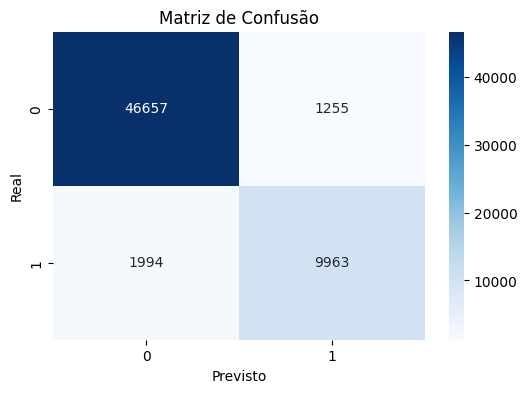

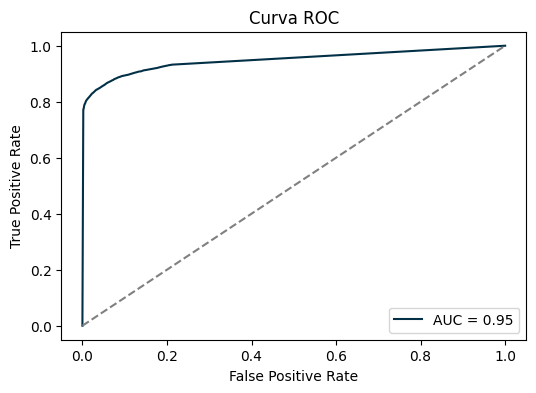

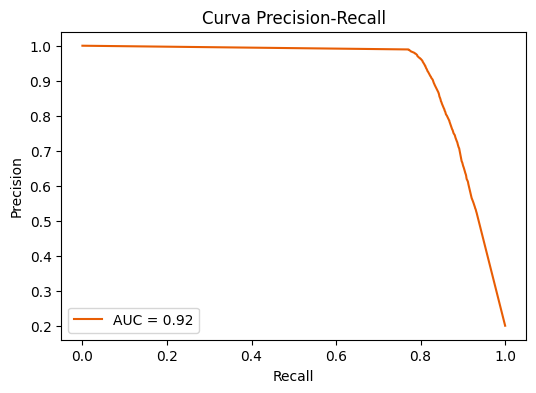

c:\Users\renan\Documents\Python\VSCode\Pratica DS\src\eda_utils.py:145: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(erro, bins=2, palette=palette)


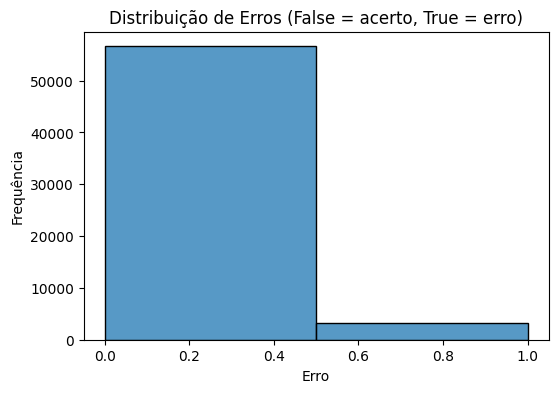

c:\Users\renan\Documents\Python\VSCode\Pratica DS\src\eda_utils.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette=palette)
c:\Users\renan\Documents\Python\VSCode\Pratica DS\src\eda_utils.py:179: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette=palette)


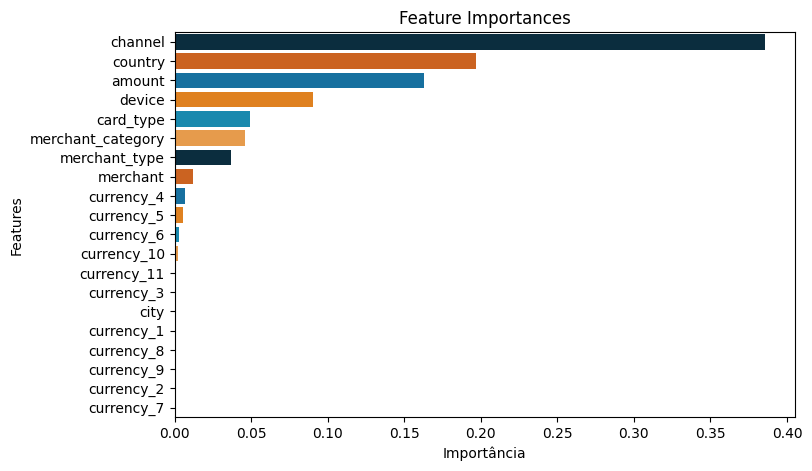

In [19]:
eda_utils.avaliar_modelo('Decision Tree', results, X_train, y_train)


Avaliando modelo: Random Forest
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     47912
        True       0.97      0.82      0.89     11957

    accuracy                           0.96     59869
   macro avg       0.96      0.91      0.93     59869
weighted avg       0.96      0.96      0.96     59869



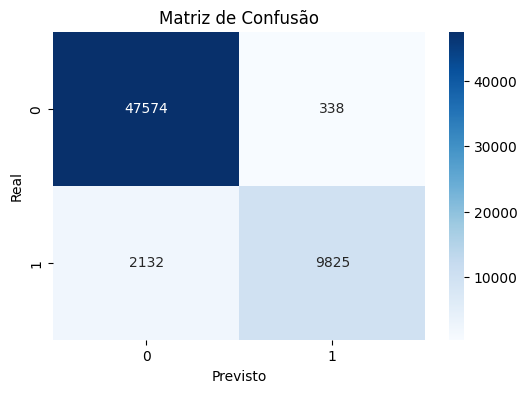

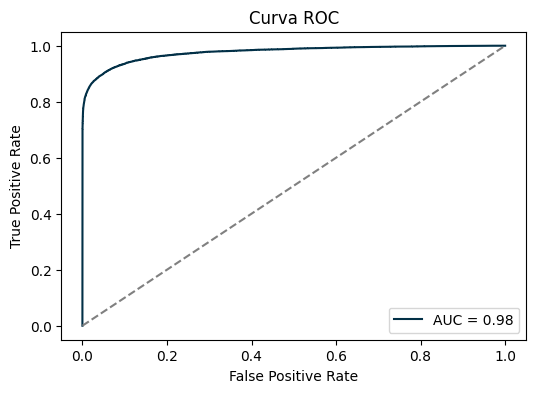

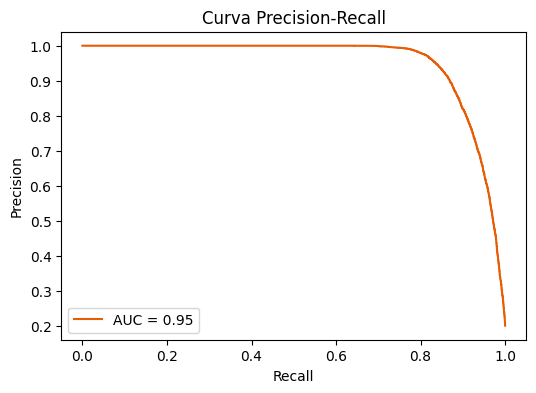

c:\Users\renan\Documents\Python\VSCode\Pratica DS\src\eda_utils.py:145: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(erro, bins=2, palette=palette)


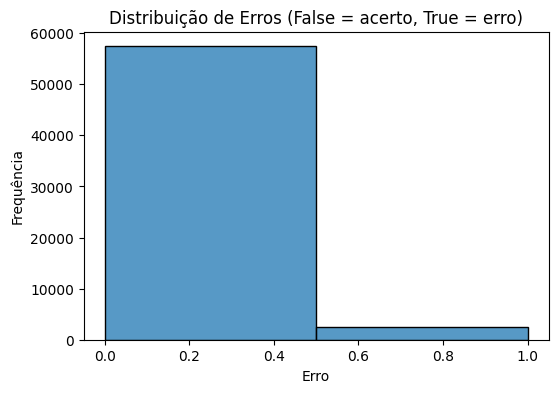

c:\Users\renan\Documents\Python\VSCode\Pratica DS\src\eda_utils.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette=palette)
c:\Users\renan\Documents\Python\VSCode\Pratica DS\src\eda_utils.py:179: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette=palette)


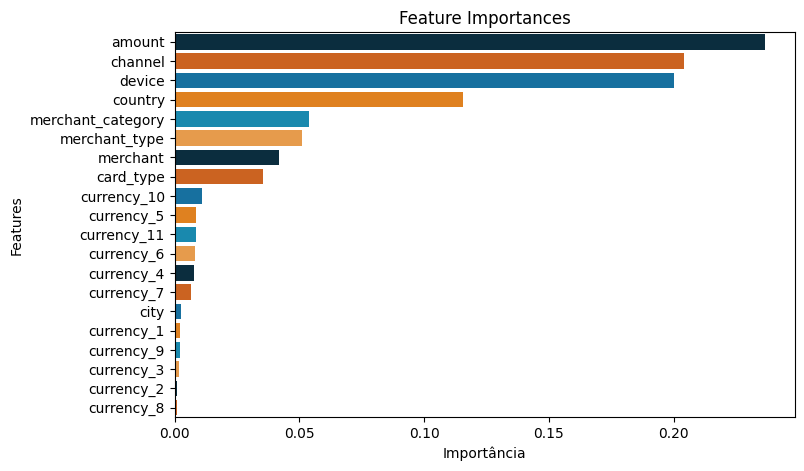

In [20]:
eda_utils.avaliar_modelo('Random Forest', results, X_train, y_train)

| Métrica             | Decision Tree | Random Forest  |
|---------------------|---------------|----------------|
| Acurácia            | 0.95          | 0.96           |
| Recall (True)       | 0.83          | 0.82           |
| Recall (False)      | 0.97          | 0.99           |
| Precision (True)    | 0.89          | 0.97           |
| Precision (False)   | 0.96          | 0.96           |
| F1-Score (True)     | 0.86          | 0.89           |
| F1-Score (False)    | 0.97          | 0.97           |
| ROC                 | 0.95          | 0.98           |
| PR                  | 0.92          | 0.95           |

Apesar do modelo Random Forest ter uma performace de 0,01% inferior no recall com relação ao modelo Decision Tree, que é uma métrica muito importante, ainda mais se tratando da categoria True, iremos seguir com ele, pois as demais métricas são superiores e mais equibradas.

### Etapa 7 - Avaliação final do modelo

Agora testamos o modelo treinado no conjunto de teste, dados que ele nunca viu.  

Avaliaremos:
- Precisão, Recall, F1-Score (essencial para fraudes, já que os dados são desbalanceados);
- AUC-ROC para verificar separabilidade entre classes;
- Matriz de confusão para analisar os erros mais comuns.

In [35]:
pipeline = results['Random Forest']['best_estimator_']

preprocessor = pipeline.named_steps['preprocessor']
classifier = pipeline.named_steps['classifier']

importances = classifier.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
top_features = feat_imp.head(10).index.tolist() 

print("\nTop Features Selecionadas:")
print(top_features)


Top Features Selecionadas:
['num__amount', 'target_enc__channel', 'target_enc__device', 'target_enc__country', 'target_enc__merchant_category', 'target_enc__merchant_type', 'target_enc__merchant', 'ordinal_enc__card_type', 'onehot__currency_10', 'onehot__currency_5']


Utilizamos feature_importances da Random Forest para identificar as 10 variáveis mais relevantes na previsão. Essa técnica ajuda a reduzir a dimensionalidade e concentrar a modelagem nas variáveis com maior poder preditivo, além de facilitar a interpretação.


In [36]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_top = pd.DataFrame(X_train_transformed, columns=feature_names)[top_features]
X_test_top = pd.DataFrame(X_test_transformed, columns=feature_names)[top_features]

Refizemos o treinamento do modelo com apenas as 10 variáveis mais importantes. Isso reduz a complexidade do modelo, acelera o treinamento e pode até melhorar a generalização, evitando ruídos de variáveis menos relevantes.

In [37]:
raw_params = results['Random Forest']['best_params']
best_params = {k.split('__')[1]: v for k, v in raw_params.items() if k.startswith('classifier__')}
final_model = RandomForestClassifier(**best_params)

final_model.fit(X_train_top, y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=10,
                       n_estimators=150)

Criando o modelo final com os melhores hiperparametros localizados e treinando apenas com as 10 variáveis mais importantes


Relatório de Classificação:

              precision    recall  f1-score   support

       False       0.96      1.00      0.98     11978
        True       0.99      0.83      0.91      2990

    accuracy                           0.97     14968
   macro avg       0.98      0.92      0.94     14968
weighted avg       0.97      0.97      0.96     14968



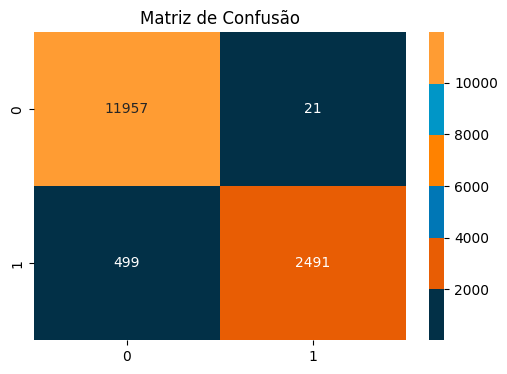

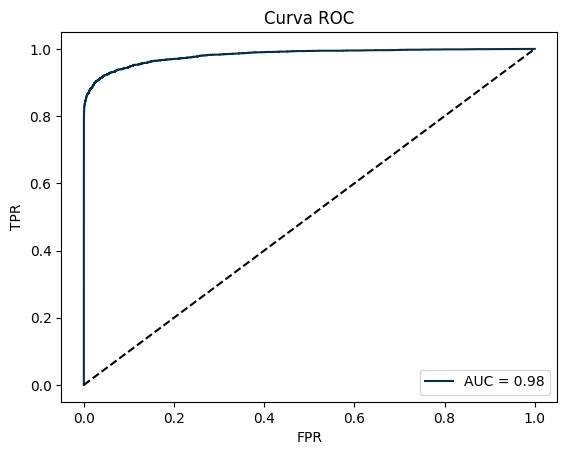

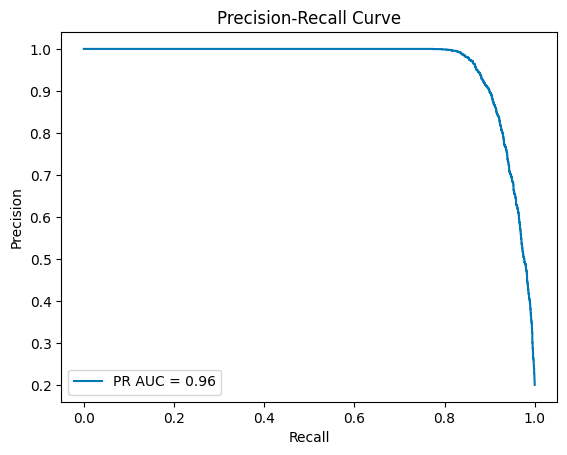

In [38]:
y_pred = final_model.predict(X_test_top)

# Classification Report
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=sns.color_palette(['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']), fmt='d')
plt.title("Matriz de Confusão")
plt.show()

# ROC Curve
y_proba = final_model.predict_proba(X_test_top)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color=sns.color_palette(['#023047'])[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# Precision-Recall Curve
y_scores = final_model.predict_proba(X_test_top)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}', color='#0077b6')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Gerando novamente as métricas do modelo agora já com todos os tratamentos aplicados para verificar se houve diferença no resultado.  
As métricas continuam muito semelhantes, porém agora o modelo está mais rápido, mais facil de ser explicado, com redução de dimensionalidade para versões futuras do pipeline e com uma melhor visualização das variáveis que realmente importam

In [ ]:
explainer = shap.Explainer(final_model.predict, X_train_top)
shap_values = explainer(X_train_top)

shap.plots.beeswarm(shap_values)

ExactExplainer explainer:   1%|          | 675/59869 [07:27<8:17:52,  1.98it/s] 

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
erro_fp = (y_pred == 1) & (y_train == 0)
idx_fp = np.where(erro_fp)[0][0]

shap.plots.waterfall(shap_values[idx_fp])